# Howework 3: Optimization (Part 2, Optimization via Stochastic Gradient Descent)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

np.random.seed(42)

### Optimizers definition

In [2]:
def stochastic_gradient_descent(X, Y, loss, grad_loss, theta0, alpha, batch_size, n_epochs):
    N = X.shape[0]
    idx = np.arange(0, N)

    theta_history = []
    loss_history = []
    grad_norm_history = []
    theta_k = theta0

    for _ in range(n_epochs):
        np.random.shuffle(idx)
        X = X[idx]
        Y = Y[idx]

        grad_loss_vec = []

        for batch_start in range(0, N, batch_size):
            batch_end = min(batch_start + batch_size, N)
            X_batch = X[batch_start:batch_end]
            y_batch = Y[batch_start:batch_end]

            gradient = grad_loss(theta_k, X_batch, y_batch)
            grad_loss_vec.append(np.linalg.norm(gradient, 2))

            theta_k = theta_k - alpha * gradient

        theta_history.append(theta_k)
        loss_history.append(loss(theta_k, X, Y))
        grad_norm_history.append(np.mean(grad_loss_vec))

    return theta_history, loss_history, grad_norm_history

In [3]:
def gradient_descent(X, Y, loss, grad_loss, alpha, maxit, tolx, tolf, x0, backtracking=None):
    theta_k = x0
    theta_old = np.inf
    theta_k_history = []
    theta_k_history.append(theta_k)

    grad_norm_0 = np.linalg.norm(grad_loss(theta_k, X, Y), 2)
    grad_norm_history = [grad_norm_0]
    grad_norm_k = grad_norm_0

    f_val_k = loss(theta_k, X, Y)
    f_val_history = [f_val_k]

    k = 0
    while (k < maxit and
           np.linalg.norm(theta_k - theta_old, 2) >= tolx and
           grad_norm_k >= tolf*grad_norm_0):

        if backtracking is not None:
            alpha = backtracking(loss, grad_loss, theta_k, X, Y)

        theta_old = theta_k
        theta_k = theta_k - alpha*grad_loss(theta_k, X, Y)
        theta_k_history.append(theta_k)

        grad_norm_k = np.linalg.norm(grad_loss(theta_k, X, Y), 2)
        grad_norm_history.append(grad_norm_k)

        f_val_k = loss(theta_k, X, Y)
        f_val_history.append(f_val_k)

        k += 1

    return theta_k_history, k, f_val_history, grad_norm_history

In [4]:
def backtracking(f, grad_f, theta, X, Y):
    """
    This function is a simple implementation of the backtracking algorithm for
    the GD (Gradient Descent) method.

    f: function. The function that we want to optimize.
    grad_f: function. The gradient of f(x).
    x: ndarray. The actual iterate x_k.
    """
    alpha = 1
    c = 0.8
    tau = 0.25

    while f(theta - alpha * grad_f(theta, X, Y), X, Y) > f(theta, X, Y) - c * alpha * np.linalg.norm(grad_f(theta, X, Y), 2) ** 2:
        alpha = tau * alpha
        if alpha < 1e-3:
            break
    return alpha

### Data preparation

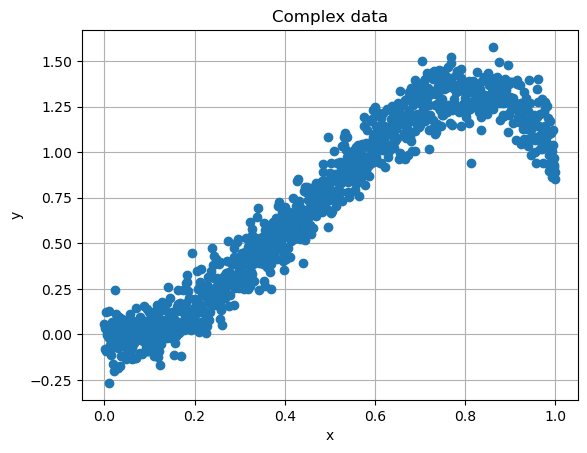

In [5]:
polynomial_degree = 1
data = pd.read_csv('./data/poly_regression_large.csv')

plt.plot(data['x'], data['y'], 'o')
plt.title("Complex data")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

In [6]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

train_size = int(0.8 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

X_train = np.array(train_data['x'])
y_train = np.array(train_data['y'])
X_test = np.array(test_data['x'])
y_test = np.array(test_data['y'])

print(f"X train: {X_train.shape}, y train: {y_train.shape}")


X train: (800,), y train: (800,)


In [7]:
data_small = pd.read_csv('./data/poly_regression_small.csv')
data_small = data_small.sample(frac=1, random_state=42).reset_index(drop=True)
X_train_small, y_train_small = data_small["x"], data_small['y']

In [8]:
def Phi(X, K):
    Phi = np.vander(X, K, increasing=True)
    return Phi

In [9]:
def loss1(theta, X, Y):
    PhiX = Phi(X, len(theta))
    return np.mean(np.linalg.norm((PhiX @ theta - Y) ** 2, 2))

def grad_loss1(theta, X, Y):
    PhiX = Phi(X, len(theta))
    return PhiX.T @ (PhiX @ theta - Y)

def loss(theta, X, Y):
    return np.mean(np.linalg.norm((X @ theta - Y) ** 2, 2))

def grad_loss(theta, X, Y):
    return X.T @ (X @ theta - Y)


In [10]:
def sort_for_plotting(X, y):
    combined = np.hstack((X.reshape(-1, 1), y.reshape(-1, 1)))
    combined_sorted = combined[np.argsort(combined[:, 0])]

    X_sorted = combined_sorted[:, 0]
    y_sorted = combined_sorted[:, 1]
    return X_sorted, y_sorted


### Model comparison

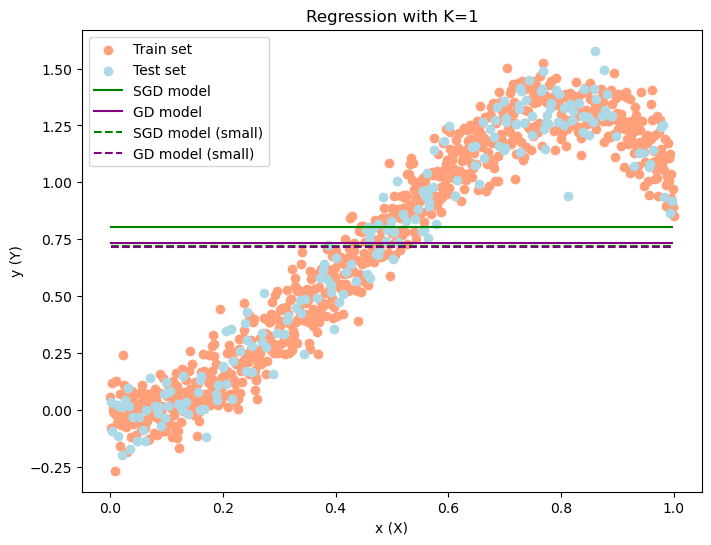

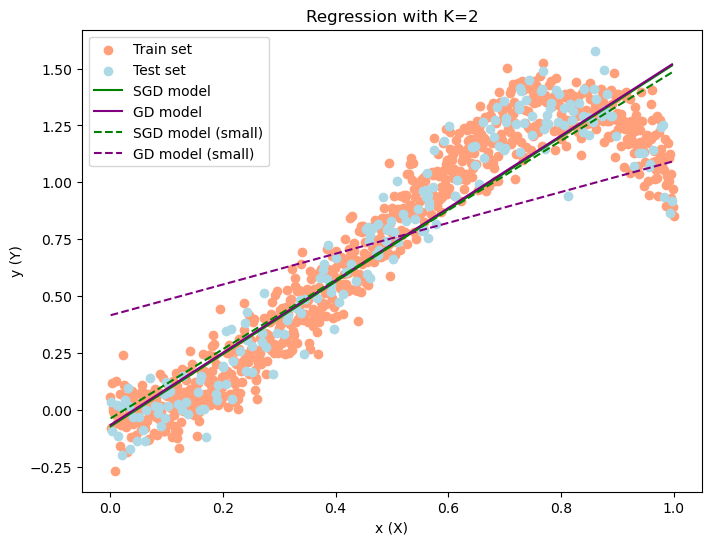

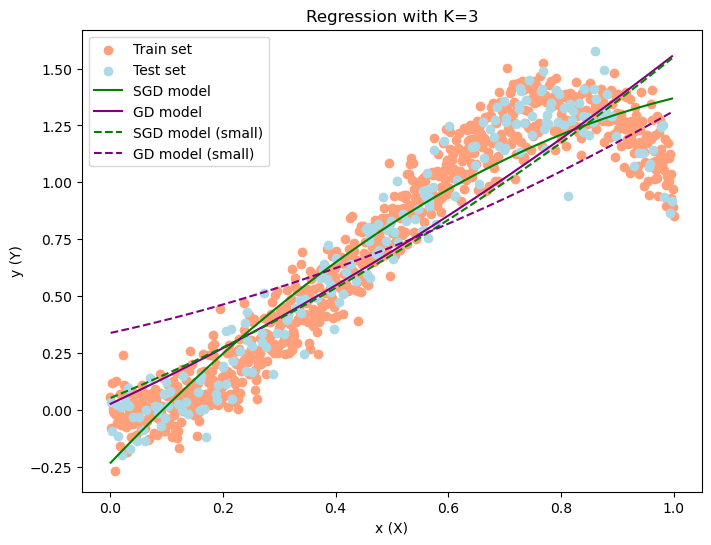

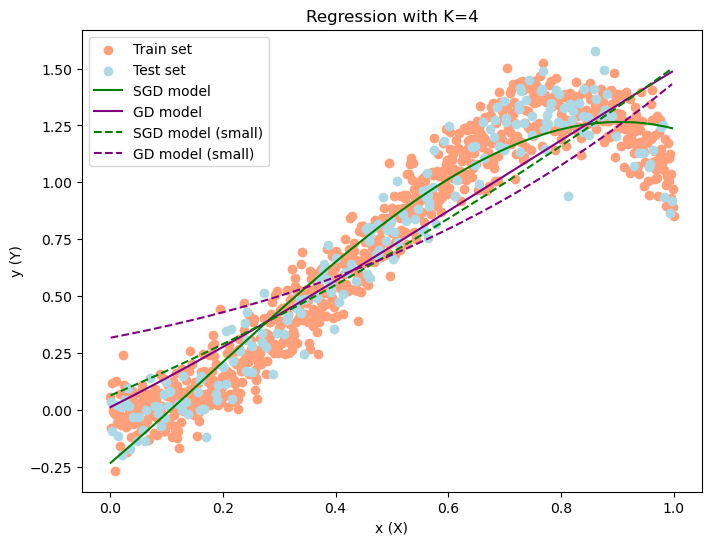

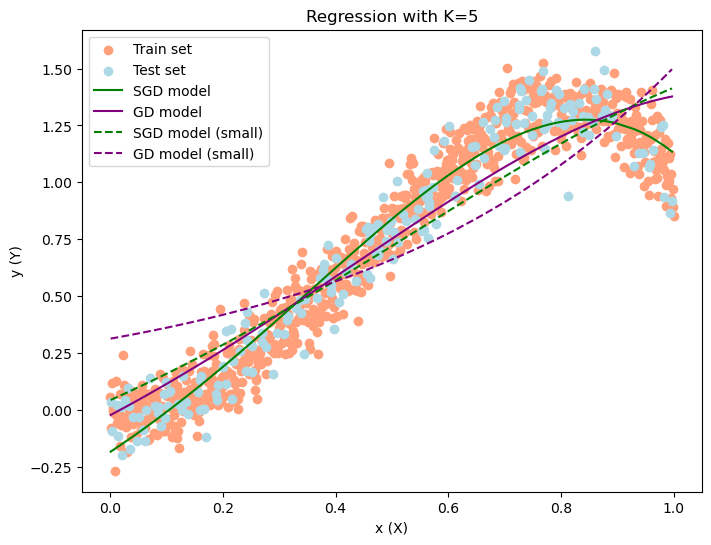

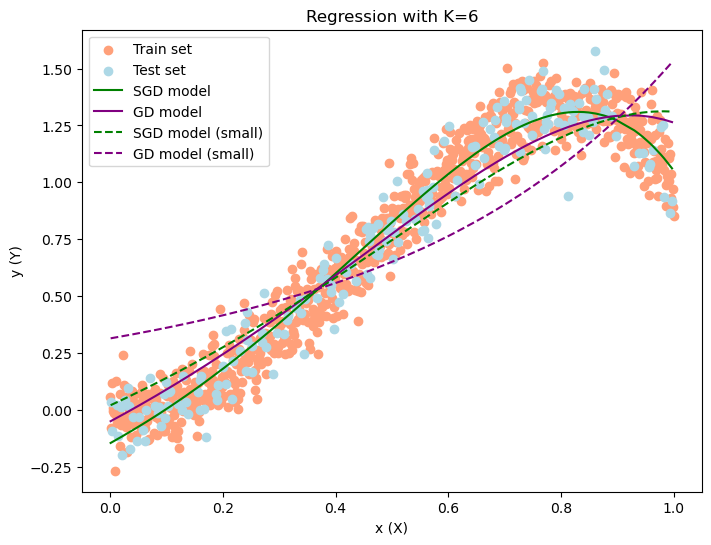

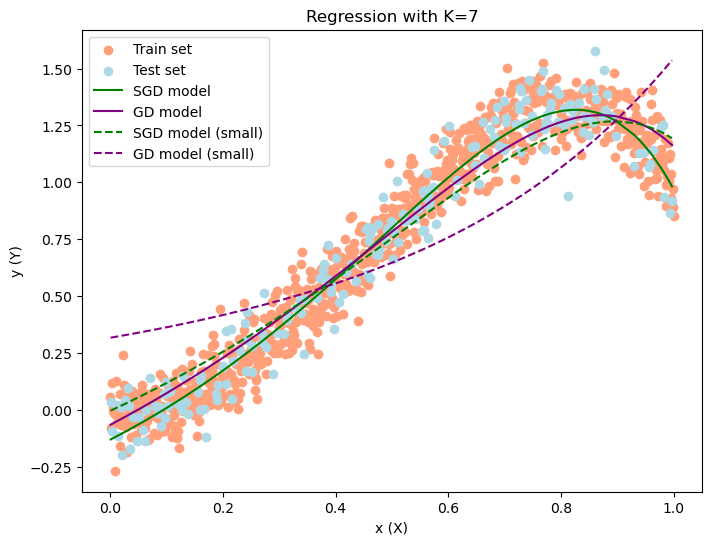

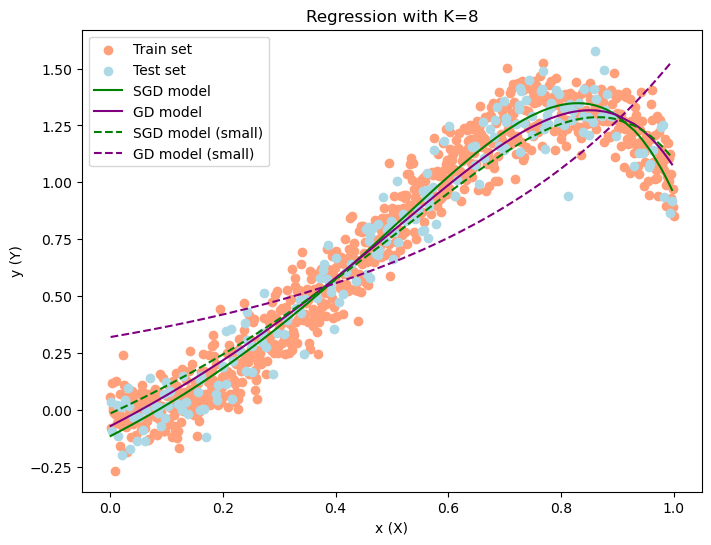

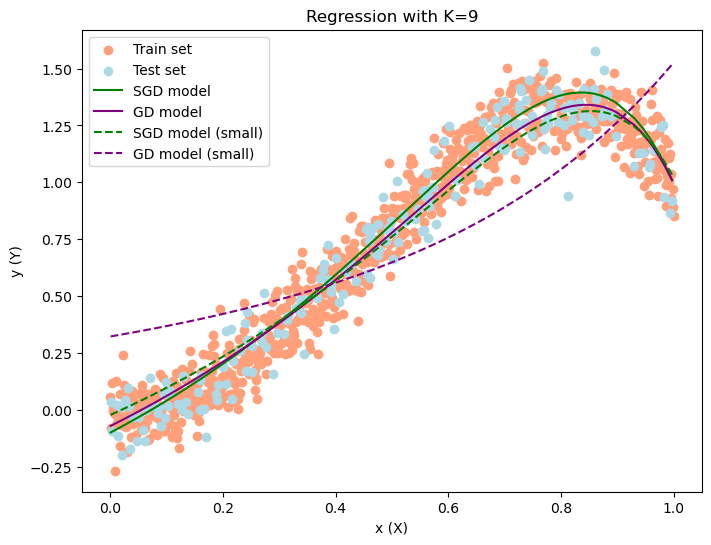

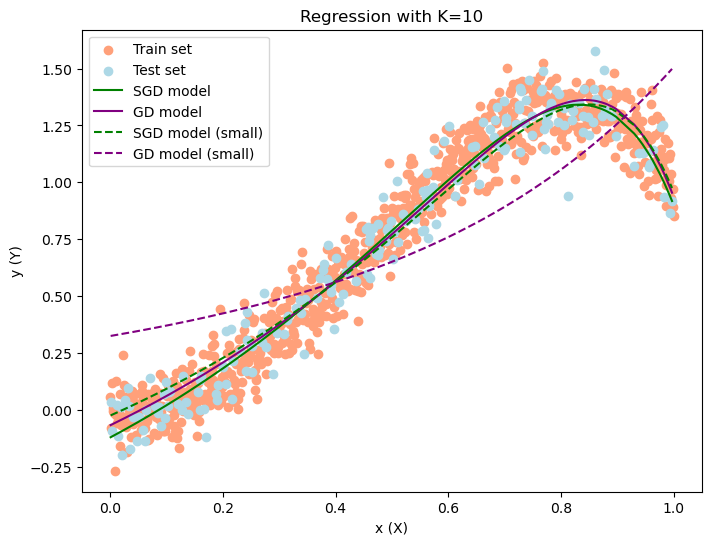

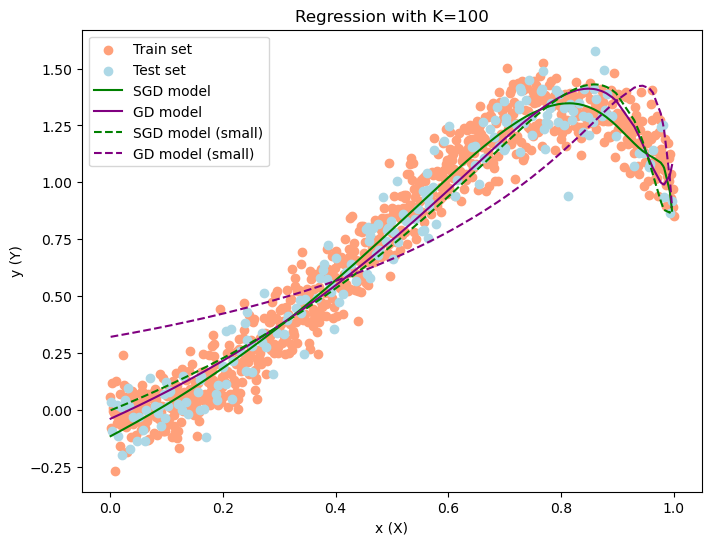

In [11]:
Ks = list(np.arange(1, 11, 1))
Ks.append(100)
n_epochs = 100
lr = 0.01
batch_size = 32

errors_sgd = []
errors_gd = []
errors_sgd_small = []
errors_gd_small = []

params = {}

for K in Ks :
    params[K] = {}
    PhiX = Phi(X_train, K)
    PhiX_test = Phi(X_test, K)
    PhiX_small = Phi(X_train_small, K)

    theta0 = np.zeros(K)

    theta_history_sgd, _, _ = stochastic_gradient_descent(
        X_train, y_train, loss1, grad_loss1, theta0, lr, batch_size, n_epochs)
    y_pred_sgd = PhiX_test @ theta_history_sgd[-1]
    errors_sgd.append(np.mean((y_pred_sgd - y_test)**2))
    params[K]['sgd'] = theta_history_sgd[-1]

    theta_history_gd, _, _, _ = gradient_descent(
        PhiX, y_train, loss, grad_loss, alpha=None, maxit=n_epochs,
        tolx=1e-5, tolf=1e-5, x0=theta0, backtracking=backtracking)
    y_pred_gd = PhiX_test @ theta_history_gd[-1]
    errors_gd.append(np.mean((y_pred_gd - y_test)**2))
    params[K]['gd'] = theta_history_gd[-1]

    theta_history_sgd_small, loss_his, _ = stochastic_gradient_descent(
        X_train_small, y_train_small, loss1, grad_loss1, theta0, lr, batch_size, n_epochs)
    y_pred_sgd_small = PhiX_test @ theta_history_sgd_small[-1]
    errors_sgd_small.append(np.mean((y_pred_sgd_small - y_test)**2))
    params[K]['sgd_small'] = theta_history_sgd_small[-1]

    theta_history_gd_small, _, _, _ = gradient_descent(
        PhiX_small, y_train_small, loss, grad_loss, alpha=None, maxit=n_epochs,
        tolx=1e-5, tolf=1e-5, x0=theta0, backtracking=backtracking)
    y_pred_gd_small = PhiX_test @ theta_history_gd_small[-1]
    errors_gd_small.append(np.mean((y_pred_gd_small - y_test)**2))
    params[K]['gd_small'] = theta_history_gd_small[-1]


    X_test_sorted, y_pred_sgd = sort_for_plotting(X_test, y_pred_sgd)
    _, y_pred_gd = sort_for_plotting(X_test, y_pred_gd)
    _, y_pred_sgd_small = sort_for_plotting(X_test, y_pred_sgd_small)
    _, y_pred_gd_small = sort_for_plotting(X_test, y_pred_gd_small)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_train, y_train, color='lightsalmon', label='Train set')
    plt.scatter(X_test, y_test, color='lightblue', label='Test set')
    plt.plot(X_test_sorted, y_pred_sgd, color='green', label='SGD model')
    plt.plot(X_test_sorted, y_pred_gd, color='purple', label='GD model')
    plt.plot(X_test_sorted, y_pred_sgd_small, color='green', linestyle='dashed', label='SGD model (small)')
    plt.plot(X_test_sorted, y_pred_gd_small, color='purple', linestyle='dashed', label='GD model (small)')
    plt.title(f'Regression with K={K}')
    plt.xlabel('x (X)')
    plt.ylabel('y (Y)')
    plt.legend()
    plt.show()

All models have similar behaviour. However, we can se that in the extreme case of K=100, all functions overfit, albeit to different degrees:
- the plot show how GD is more prone to overfit compared to SGD.
- in addition, the models on the small dataset also are more prone to overfitting compared to the their other counterparts computed on the bigger dataset.

These observations have been made based on the "wobbliness" of the graph.

##### Plotting the errors

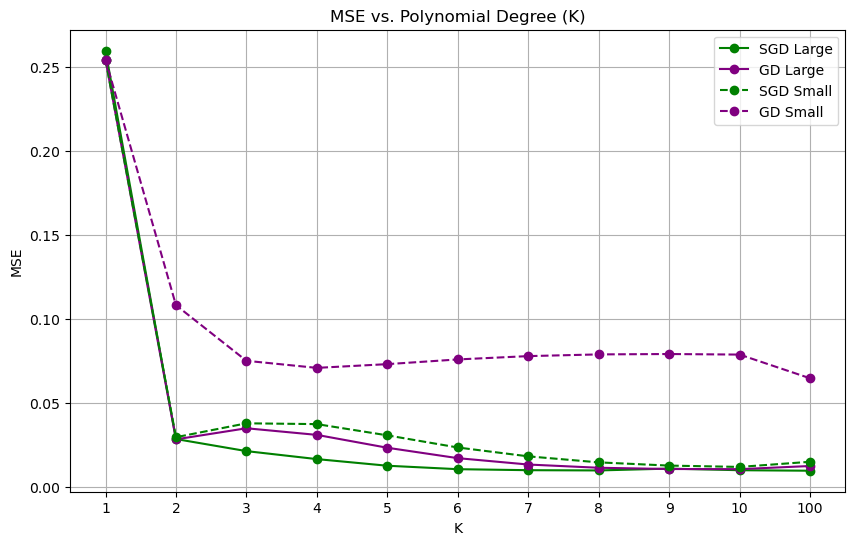

In [12]:
import matplotlib.pyplot as plt

def plot_errors_vs_k(Ks, errors_sgd, errors_gd, errors_sgd_small, errors_gd_small):
    x_positions = range(len(Ks))
    plt.figure(figsize=(10, 6))
    plt.plot(x_positions, errors_sgd, label="SGD Large", color='green', marker='o')
    plt.plot(x_positions, errors_gd, label="GD Large", color='purple', marker='o')
    plt.plot(x_positions, errors_sgd_small, label="SGD Small", color='green', linestyle='dashed', marker='o')
    plt.plot(x_positions, errors_gd_small, label="GD Small", color='purple', linestyle='dashed', marker='o')

    plt.xticks(ticks=x_positions, labels=Ks)

    plt.xlabel("K")
    plt.ylabel("MSE")
    plt.title("MSE vs. Polynomial Degree (K)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_errors_vs_k(Ks, errors_sgd, errors_gd, errors_sgd_small, errors_gd_small)

By analyzing the graph, we can see how SGD with the large dataset performs the best.

When using the small dataset, SGD is able to generalize more effectively than GD (as also documented in this paper [here](https://cbmm.mit.edu/sites/default/files/publications/The_Janus_effects_of_SGD_vs_GD__high_noise_and_low_rank_0.pdf)). GD on the other hand is much more prone to the noise that may be present in the data, and as such is the lowest performant technique when using a smaller dataset.

With a big enough dataset however, SGD and GD perform very similarly.

### $K=5$ and comparison with $\theta^*$

[-0.18483015  1.63752571  1.24600454 -0.13568819 -1.43403682]


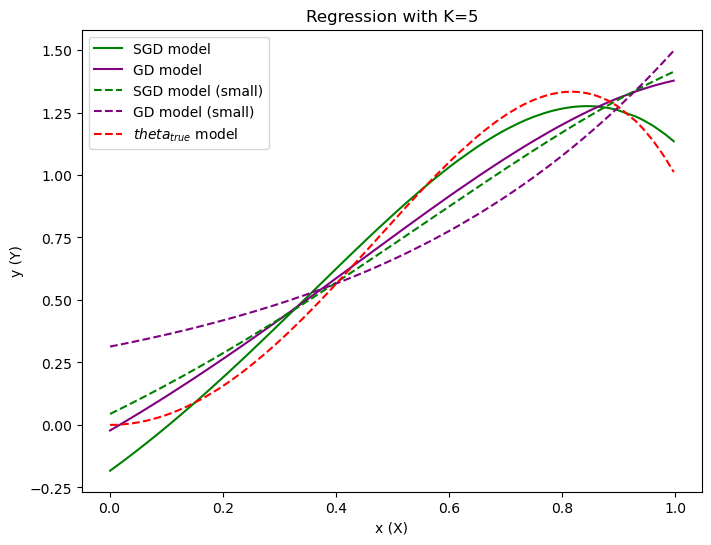

In [13]:
theta_true = np.array([0,0,4,0,-3])
K = 5
PhiX_test = Phi(X_test, K)

print(params[K]['sgd'])

y_pred_sgd = PhiX_test @ params[K]['sgd']
y_pred_gd = PhiX_test @ params[K]['gd']
y_pred_sgd_small = PhiX_test @ params[K]['sgd_small']
y_pred_gd_small = PhiX_test @ params[K]['gd_small']
y_original = PhiX_test @ theta_true

X_test_sorted, y_pred_sgd = sort_for_plotting(X_test, y_pred_sgd)
_, y_pred_gd = sort_for_plotting(X_test, y_pred_gd)
_, y_pred_sgd_small = sort_for_plotting(X_test, y_pred_sgd_small)
_, y_pred_gd_small = sort_for_plotting(X_test, y_pred_gd_small)
_, y_original = sort_for_plotting(X_test, y_original)


plt.figure(figsize=(8, 6))

plt.plot(X_test_sorted, y_pred_sgd, color='green', label='SGD model')
plt.plot(X_test_sorted, y_pred_gd, color='purple', label='GD model')
plt.plot(X_test_sorted, y_pred_sgd_small, color='green', linestyle='dashed', label='SGD model (small)')
plt.plot(X_test_sorted, y_pred_gd_small, color='purple', linestyle='dashed', label='GD model (small)')
plt.plot(X_test_sorted, y_original, color='red', linestyle='dashed', label='$theta_{true}$ model')

plt.title(f'Regression with K={K}')
plt.xlabel('x (X)')
plt.ylabel('y (Y)')
plt.legend()
plt.show()


In [14]:
for i in params[5].items():
    print(f"theta for {i[0]}: {i[1]}")

print("\nreal theta:", theta_true)

theta for sgd: [-0.18483015  1.63752571  1.24600454 -0.13568819 -1.43403682]
theta for gd: [-0.02338507  1.31641942  0.60952748 -0.03727104 -0.48630182]
theta for sgd_small: [ 0.04284558  1.10667928  0.55993003  0.04008689 -0.33340946]
theta for gd_small: [0.31306095 0.44651779 0.33679264 0.23974493 0.1686859 ]

real theta: [ 0  0  4  0 -3]
